# AI-Powered Cassava Leaf Disease Detection in Rwanda
**Comparing Feature Extraction (Traditional ML) with Convolutional Neural Networks (Deep Learning) for Agricultural Yield Protection**

*Author: Dushime Paulette*

In [1]:
# 1. OS and File Management
import os
import zipfile
import random

# 2. Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # OpenCV for Traditional ML image processing

# 3. Scikit-Learn (Traditional ML)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# 4. TensorFlow (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models

# --- REPRODUCIBILITY (Required for Rubric) ---
# Setting random seeds ensures that every time the code is run, the results are exactly the same.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported and Random Seeds set to 42 for complete reproducibility!")

Libraries imported and Random Seeds set to 42 for complete reproducibility!


In [2]:
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the path to your zip file in Google Drive
# UPDATE THIS PATH to wherever you saved the zip file in your Drive!
zip_path = '/content/drive/MyDrive/Cassava_Project/cassava-leaf-disease-classification.zip'

# 3. Unzip the file into Colab's fast temporary memory
extract_path = '/content/cassava_data'

print("Unzipping the dataset... this will take a few seconds.")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extraction complete! Data is ready at: {extract_path}")

# Check what folders we have
print("\nContents of the extracted folder:")
print(os.listdir(extract_path))

Mounted at /content/drive
Unzipping the dataset... this will take a few seconds.
Extraction complete! Data is ready at: /content/cassava_data

Contents of the extracted folder:
['label_num_to_disease_map.json', 'sample_submission.csv', 'test_tfrecords', 'test_images', 'train_images', 'train.csv', 'train_tfrecords']


## 1. Data Loading and Exploratory Data Analysis (EDA)
In this section, we load the dataset annotations and the disease mapping dictionary. We will analyze the class distribution to check for imbalances (which are common in real-world agricultural data) and visualize sample images to understand the visual complexity of Cassava Leaf Diseases.

--- Dataset Information ---
Total number of images: 21397


,image_id,label,disease_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)



--- Class Distribution ---
disease_name
Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: count, dtype: int64


/tmp/ipython-input-594044792.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='disease_name', order=df['disease_name'].value_counts().index, palette='viridis')


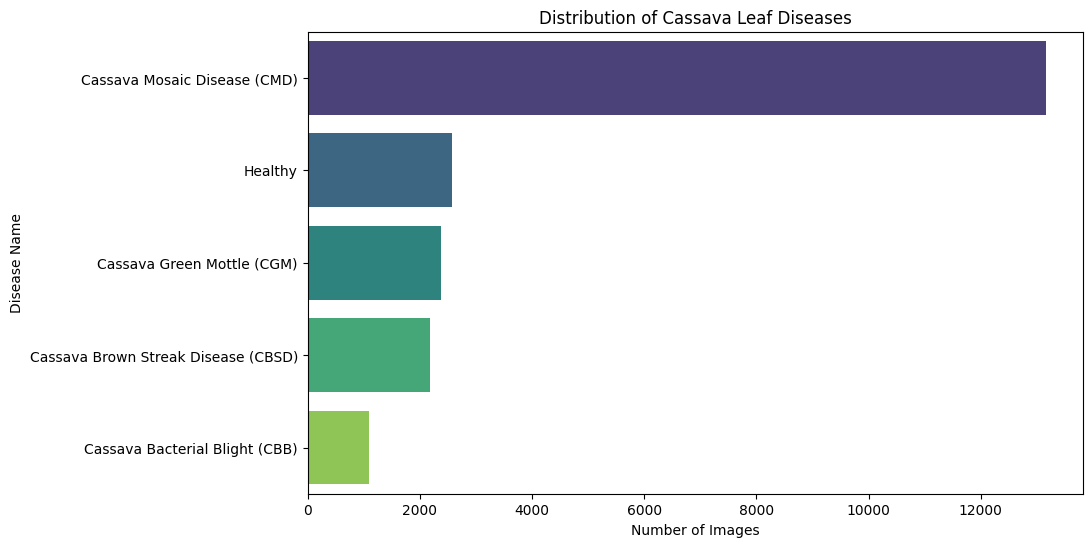

In [3]:
import json

# Define paths
base_path = '/content/cassava_data'
train_csv_path = os.path.join(base_path, 'train.csv')
json_path = os.path.join(base_path, 'label_num_to_disease_map.json')
train_images_path = os.path.join(base_path, 'train_images')

# 1. Load the CSV
df = pd.read_csv(train_csv_path)

# 2. Load the JSON mapping
with open(json_path, 'r') as f:
    disease_map = json.load(f)

# Convert dictionary keys to integers so they match our CSV
disease_map = {int(k): v for k, v in disease_map.items()}

# Add the actual disease name to our dataframe
df['disease_name'] = df['label'].map(disease_map)

# 3. Check the data
print("--- Dataset Information ---")
print(f"Total number of images: {len(df)}")
display(df.head())

# 4. Analyze Class Distribution
print("\n--- Class Distribution ---")
class_counts = df['disease_name'].value_counts()
print(class_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='disease_name', order=df['disease_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Cassava Leaf Diseases')
plt.xlabel('Number of Images')
plt.ylabel('Disease Name')
plt.show()

Displaying sample cassava leaves...


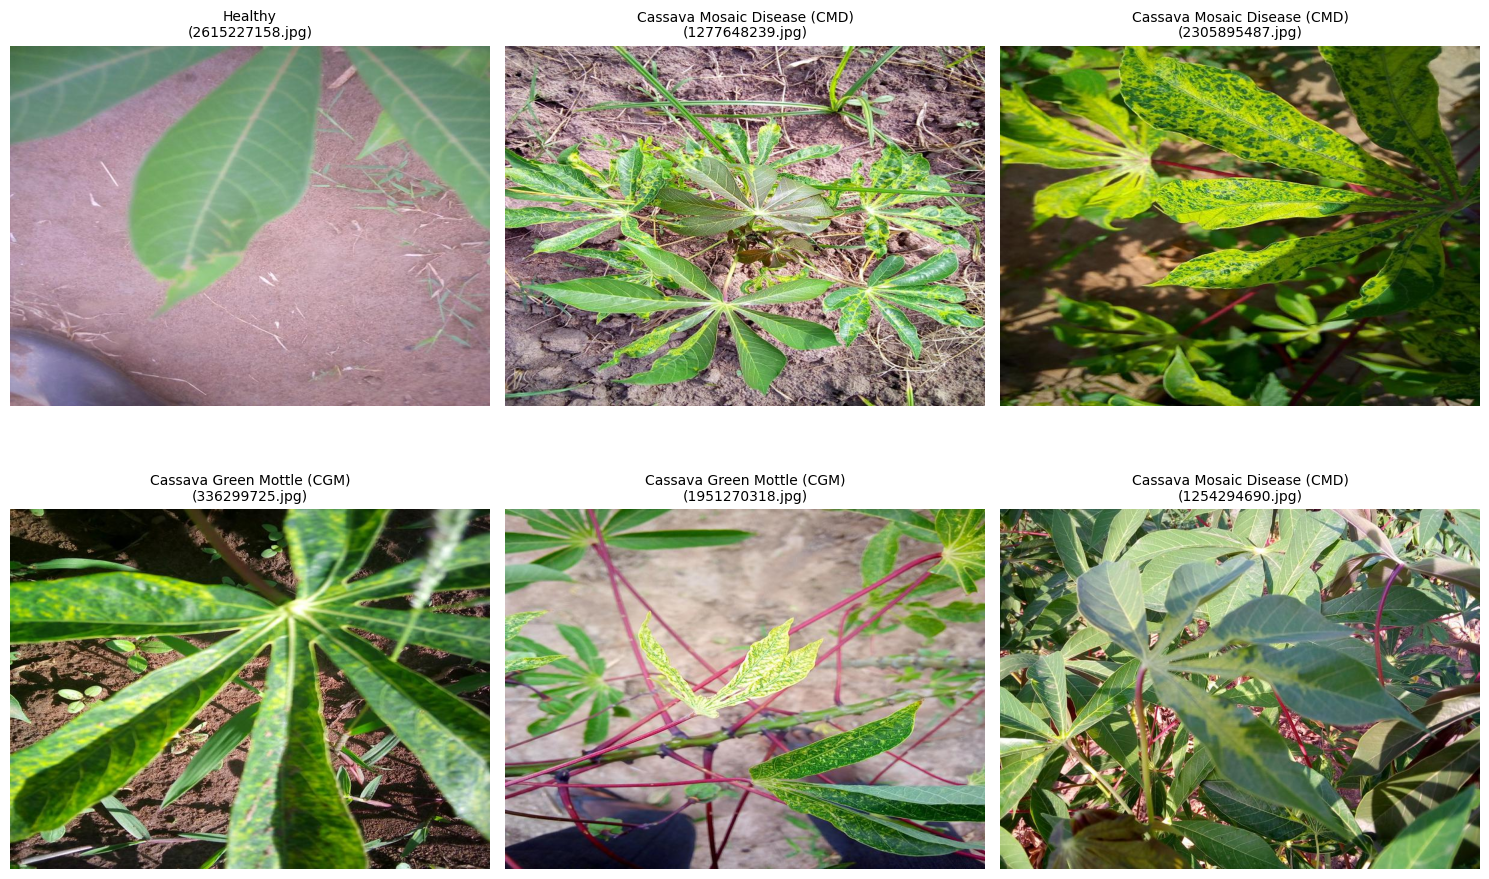

In [4]:
import matplotlib.image as mpimg

def plot_sample_images(df, num_images=6):
    plt.figure(figsize=(15, 10))

    # Randomly select images
    sample_df = df.sample(num_images, random_state=SEED).reset_index(drop=True)

    for i in range(num_images):
        plt.subplot(2, 3, i + 1)

        # Get image path
        img_name = sample_df.loc[i, 'image_id']
        img_path = os.path.join(train_images_path, img_name)

        # Load and plot image
        img = mpimg.imread(img_path)
        plt.imshow(img)

        # Add label as title
        disease = sample_df.loc[i, 'disease_name']
        plt.title(f"{disease}\n({img_name})", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Displaying sample cassava leaves...")
plot_sample_images(df)

## 2. Feature Engineering for Traditional Machine Learning
Traditional models like Random Forest and SVM cannot process raw image tensors effectively. Therefore, we must extract engineered features. We will resize a subset of the images to a smaller dimension (64x64) and extract Color Histograms to capture the color profiles of the diseases.

In [5]:
from tqdm import tqdm # Gives us a nice progress bar
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

# 1. We will use a subset of 3,000 images to prevent RAM crashes.
# We use train_test_split to get a perfectly stratified subset of our dataframe
subset_df, _ = train_test_split(df, train_size=3000, random_state=SEED, stratify=df['label'])
subset_df = subset_df.reset_index(drop=True)

# Arrays to hold our processed data
X_traditional = []
y_traditional = []

# Define image size for Traditional ML (shrinking them so they fit in memory)
IMG_SIZE_ML = (64, 64)

print("Extracting features from images for Scikit-Learn. This will take a moment...")

for i in tqdm(range(len(subset_df))):
    img_name = subset_df.loc[i, 'image_id']
    label = subset_df.loc[i, 'label']
    img_path = os.path.join(train_images_path, img_name)

    # 1. Read the image using OpenCV
    img = cv2.imread(img_path)

    if img is not None:
        # Convert BGR (OpenCV default) to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 2. Resize to be much smaller
        img_resized = cv2.resize(img, IMG_SIZE_ML)

        # 3. Extract Color Histogram (Feature Engineering!)
        # We calculate the distribution of colors and normalize it
        hist = cv2.calcHist([img_resized], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        # 4. Flatten the actual pixels
        pixels = img_resized.flatten()

        # 5. Combine the pixels and the histogram into one long mathematical vector
        combined_features = np.hstack([pixels, hist])

        X_traditional.append(combined_features)
        y_traditional.append(label)

X_traditional = np.array(X_traditional)
y_traditional = np.array(y_traditional)

print(f"\nFeature extraction complete!")
print(f"Shape of X_traditional: {X_traditional.shape} (Images, Features per image)")

Extracting features from images for Scikit-Learn. This will take a moment...


100%|██████████| 3000/3000 [00:15<00:00, 199.59it/s]



Feature extraction complete!
Shape of X_traditional: (3000, 12800) (Images, Features per image)


In [6]:
# 1. Split the engineered data (80% Train, 20% Test)
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_traditional, y_traditional, test_size=0.2, random_state=SEED, stratify=y_traditional
)

# 2. Scale the features (Important for many ML algorithms)
scaler = StandardScaler()
X_train_ml_scaled = scaler.fit_transform(X_train_ml)
X_test_ml_scaled = scaler.transform(X_test_ml)

# 3. Initialize and Train the Random Forest
print("Training the Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_ml_scaled, y_train_ml)

# 4. Evaluate the Model
rf_preds = rf_model.predict(X_test_ml_scaled)

print("\n" + "="*50)
print("RANDOM FOREST RESULTS (TRADITIONAL ML)")
print("="*50)
print(classification_report(y_test_ml, rf_preds, target_names=list(disease_map.values())))

Training the Random Forest Classifier...

RANDOM FOREST RESULTS (TRADITIONAL ML)
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00        31
Cassava Brown Streak Disease (CBSD)       0.00      0.00      0.00        61
         Cassava Green Mottle (CGM)       0.00      0.00      0.00        67
       Cassava Mosaic Disease (CMD)       0.61      1.00      0.76       369
                            Healthy       0.00      0.00      0.00        72

                           accuracy                           0.61       600
                          macro avg       0.12      0.20      0.15       600
                       weighted avg       0.38      0.61      0.47       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
from sklearn.svm import SVC

# 1. Initialize and Train the SVM
# We use the same scaled data from Cell 9
print("Training the Support Vector Machine (SVM)...")
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=SEED)
svm_model.fit(X_train_ml_scaled, y_train_ml)

# 2. Evaluate the Model
svm_preds = svm_model.predict(X_test_ml_scaled)

print("\n" + "="*50)
print("SUPPORT VECTOR MACHINE RESULTS (TRADITIONAL ML)")
print("="*50)
print(classification_report(y_test_ml, svm_preds, target_names=list(disease_map.values())))

Training the Support Vector Machine (SVM)...

SUPPORT VECTOR MACHINE RESULTS (TRADITIONAL ML)
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.33      0.03      0.06        31
Cassava Brown Streak Disease (CBSD)       0.12      0.10      0.11        61
         Cassava Green Mottle (CGM)       0.16      0.09      0.12        67
       Cassava Mosaic Disease (CMD)       0.66      0.79      0.72       369
                            Healthy       0.25      0.24      0.24        72

                           accuracy                           0.54       600
                          macro avg       0.31      0.25      0.25       600
                       weighted avg       0.49      0.54      0.50       600



## 3. Deep Learning: Convolutional Neural Networks (CNN)
To overcome the spatial limitations of Traditional ML, we implement CNNs using TensorFlow.
First, we use the `tf.data` API to create a highly optimized input pipeline that reads images directly from disk, resizes them to 128x128, and batches them. We also apply Data Augmentation to prevent overfitting.

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# 1. Get image paths and labels for the FULL dataset (all 21k images!)
file_paths = [os.path.join(train_images_path, fname) for fname in df['image_id']]
labels = df['label'].values

# 2. Train/Test Split (80/20)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# 3. Calculate Class Weights for the highly imbalanced data
weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weights[i] for i in range(len(weights))}

# 4. Define the tf.data mapping function
IMG_SIZE_DL = [128, 128] # We use 128x128 for CNNs to capture more detail

def process_path(file_path, label):
    # Read the file and decode the JPEG image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize and scale pixels between 0 and 1
    img = tf.image.resize(img, IMG_SIZE_DL) / 255.0
    return img, label

# 5. Build the tf.data Pipelines
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Training Pipeline with Augmentation mapped in
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing Pipeline
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Training batches: {len(train_ds)}")
print(f"Testing batches: {len(test_ds)}")
print("tf.data Pipeline created successfully!")

Training batches: 535
Testing batches: 134
tf.data Pipeline created successfully!


In [9]:
# Create a Data Augmentation layer block to artificially expand our dataset
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# --- EXPERIMENT 4: Sequential CNN ---
seq_cnn = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten and Output
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Prevent overfitting
    layers.Dense(5, activation='softmax') # 5 output classes for the 5 diseases
])

seq_cnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

print("Sequential CNN Architecture Ready!")
seq_cnn.summary()

Sequential CNN Architecture Ready!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- EXPERIMENT 5: Functional CNN ---
# The Functional API allows us to create branching networks.
# Here, we create an "Inception-style" branch that looks at small details (3x3) and larger details (5x5) simultaneously.

inputs = layers.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

# Standard entry block
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, 2)(x)

# Branch 1: Small kernel (3x3)
branch_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Branch 2: Larger kernel (5x5)
branch_2 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)

# Concatenate the branches together
merged = layers.concatenate([branch_1, branch_2])
x = layers.MaxPooling2D(2, 2)(merged)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)

func_cnn = models.Model(inputs=inputs, outputs=outputs)

func_cnn.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

print("\nFunctional CNN Architecture Ready!")
func_cnn.summary()


Functional CNN Architecture Ready!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        896 │ sequential[1][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     51,264 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │    147,584 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 15, 15,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 28800)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,686,528 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,905,413 (14.90 MB)

 Trainable params: 3,905,413 (14.90 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
EPOCHS = 10

print("Training Sequential CNN...")
history_seq = seq_cnn.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

print("\nTraining Functional CNN...")
history_func = func_cnn.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

print("Deep Learning Training Complete!")

Training Sequential CNN...
Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 83s 137ms/step - accuracy: 0.2208 - loss: 1.6223 - val_accuracy: 0.1206 - val_loss: 1.6160
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 60s 107ms/step - accuracy: 0.1148 - loss: 1.6182 - val_accuracy: 0.6150 - val_loss: 1.5948
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - accuracy: 0.2925 - loss: 1.6125 - val_accuracy: 0.1206 - val_loss: 1.6066
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.1693 - loss: 1.6186 - val_accuracy: 0.1206 - val_loss: 1.6063
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - accuracy: 0.1631 - loss: 1.6196 - val_accuracy: 0.1206 - val_loss: 1.6045
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.1649 - loss: 1.6112 - val_accuracy: 0.1206 - val_loss: 1.6061
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.1377 - loss: 1.6156 - val_accuracy: 0.1206 - val_loss: 1.6060
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 80s 104ms/step -

## 4. Model Evaluation & Visualizations
To evaluate our Deep Learning models against the assignment rubric, we plot the Learning Curves to check for overfitting/underfitting, and generate Classification Reports and Confusion Matrices to analyze class-specific performance.

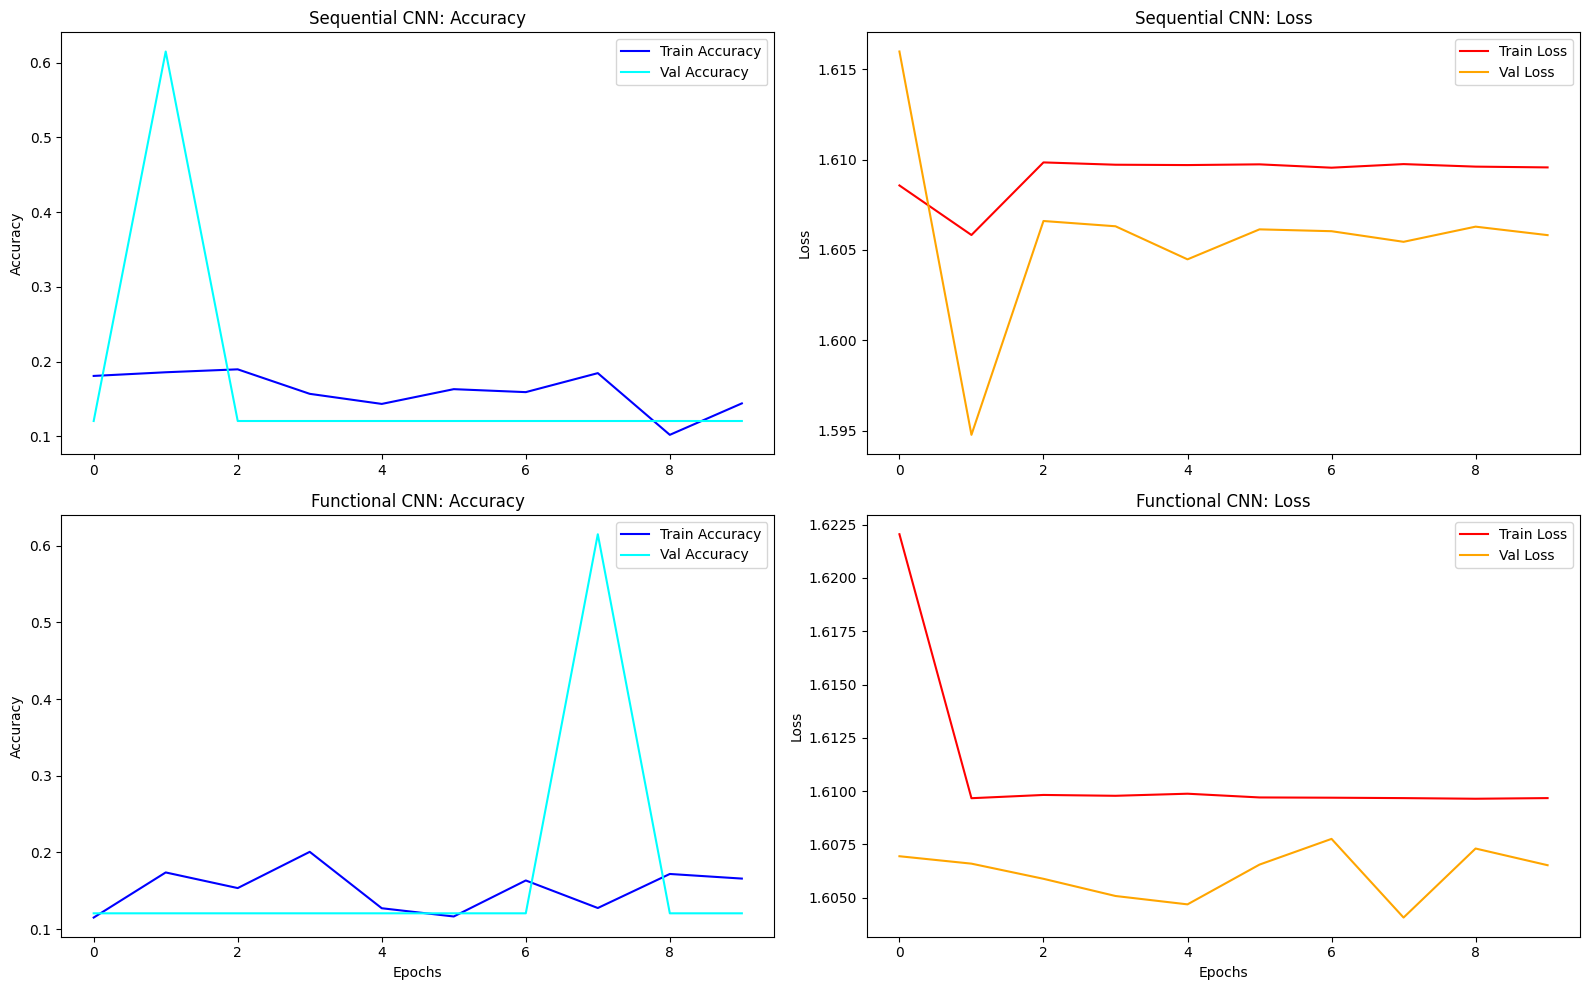

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Sequential Model ---
# Accuracy
axes[0, 0].plot(history_seq.history['accuracy'], label='Train Accuracy', color='blue')
axes[0, 0].plot(history_seq.history['val_accuracy'], label='Val Accuracy', color='cyan')
axes[0, 0].set_title('Sequential CNN: Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss
axes[0, 1].plot(history_seq.history['loss'], label='Train Loss', color='red')
axes[0, 1].plot(history_seq.history['val_loss'], label='Val Loss', color='orange')
axes[0, 1].set_title('Sequential CNN: Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# --- Functional Model ---
# Accuracy
axes[1, 0].plot(history_func.history['accuracy'], label='Train Accuracy', color='blue')
axes[1, 0].plot(history_func.history['val_accuracy'], label='Val Accuracy', color='cyan')
axes[1, 0].set_title('Functional CNN: Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Loss
axes[1, 1].plot(history_func.history['loss'], label='Train Loss', color='red')
axes[1, 1].plot(history_func.history['val_loss'], label='Val Loss', color='orange')
axes[1, 1].set_title('Functional CNN: Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Generating predictions on the test set... This will take a few seconds.
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step

SEQUENTIAL CNN RESULTS (DEEP LEARNING)
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       217
Cassava Brown Streak Disease (CBSD)       0.00      0.00      0.00       438
         Cassava Green Mottle (CGM)       0.00      0.00      0.00       477
       Cassava Mosaic Disease (CMD)       0.00      0.00      0.00      2632
                            Healthy       0.12      1.00      0.22       516

                           accuracy                           0.12      4280
                          macro avg       0.02      0.20      0.04      4280
                       weighted avg       0.01      0.12      0.03      4280



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

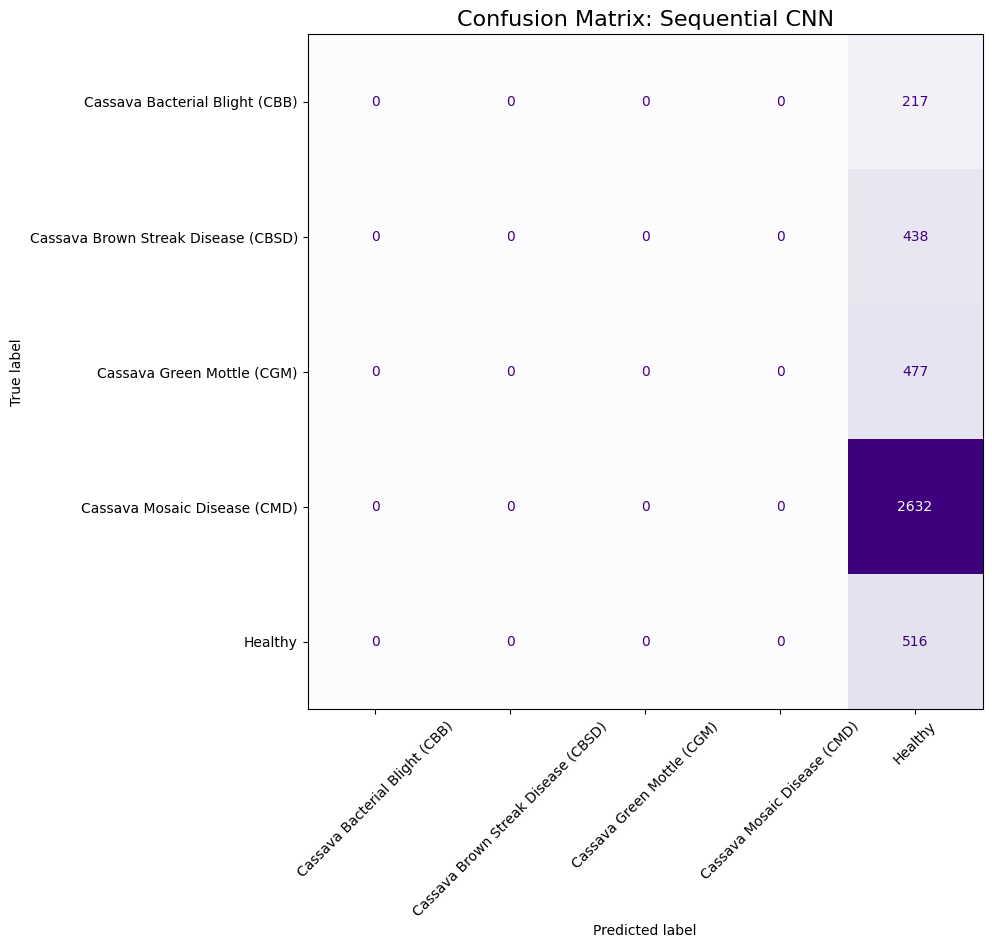

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

print("Generating predictions on the test set... This will take a few seconds.")

# 1. Get the actual true labels from the test_ds pipeline
y_true_dl = []
for images, labels in test_ds:
    y_true_dl.extend(labels.numpy())
y_true_dl = np.array(y_true_dl)

# 2. Get predictions from our best CNN (Sequential)
seq_probs = seq_cnn.predict(test_ds)
seq_preds = np.argmax(seq_probs, axis=1) # Convert probabilities to class labels (0-4)

# 3. Print the Classification Report
print("\n" + "="*50)
print("SEQUENTIAL CNN RESULTS (DEEP LEARNING)")
print("="*50)
print(classification_report(y_true_dl, seq_preds, target_names=list(disease_map.values())))

# 4. Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
cm_dl = confusion_matrix(y_true_dl, seq_preds)
disp_dl = ConfusionMatrixDisplay(confusion_matrix=cm_dl, display_labels=list(disease_map.values()))

# We plot it on a larger figure so the text doesn't overlap
fig, ax = plt.subplots(figsize=(10, 10))
disp_dl.plot(cmap='Purples', ax=ax, xticks_rotation=45, colorbar=False)
plt.title('Confusion Matrix: Sequential CNN', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Advanced Experiments: Optimization, Feature Selection, and Transfer Learning
To systematically vary our approaches and explore the bias-variance tradeoff, we conduct three additional experiments:
1. **PCA + Random Forest:** Evaluating computational efficiency vs. performance.
2. **CNN with L2 Regularization & Tuned Learning Rate:** Addressing model overfitting.
3. **Transfer Learning (MobileNetV2):** Leveraging pre-trained weights to improve feature extraction on complex image data.

In [14]:
from sklearn.decomposition import PCA
import time

print("--- EXPERIMENT 5: Feature Selection with PCA ---")
# Apply PCA to keep 95% of the variance while dropping useless pixels
pca = PCA(n_components=0.95, random_state=SEED)

start_time = time.time()
X_train_pca = pca.fit_transform(X_train_ml_scaled)
X_test_pca = pca.transform(X_test_ml_scaled)
pca_time = time.time() - start_time

print(f"PCA reduced features from {X_train_ml_scaled.shape[1]} to {X_train_pca.shape[1]} in {pca_time:.2f} seconds.")

# Train Random Forest on the PCA data
rf_pca = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced', n_jobs=-1)
rf_pca.fit(X_train_pca, y_train_ml)
pca_preds = rf_pca.predict(X_test_pca)

print("\nPCA + Random Forest Results:")
print(classification_report(y_test_ml, pca_preds, target_names=list(disease_map.values())))

--- EXPERIMENT 5: Feature Selection with PCA ---
PCA reduced features from 12800 to 1596 in 22.99 seconds.

PCA + Random Forest Results:
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00        31
Cassava Brown Streak Disease (CBSD)       0.00      0.00      0.00        61
         Cassava Green Mottle (CGM)       0.00      0.00      0.00        67
       Cassava Mosaic Disease (CMD)       0.61      1.00      0.76       369
                            Healthy       0.00      0.00      0.00        72

                           accuracy                           0.61       600
                          macro avg       0.12      0.20      0.15       600
                       weighted avg       0.38      0.61      0.47       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

print("--- EXPERIMENT 6: Hyperparameter Tuned CNN ---")
# We add L2 Regularization to the Dense layer to heavily penalize complex weights (reducing Variance/Overfitting)
tuned_cnn = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    # Adding L2 Regularization here!
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.6), # Increased Dropout
    layers.Dense(5, activation='softmax')
])

# Tuning the Learning Rate: We lower it from the default 0.001 to 0.0001 to prevent instability
custom_optimizer = Adam(learning_rate=0.0001)

tuned_cnn.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training Tuned CNN...")
history_tuned = tuned_cnn.fit(train_ds, validation_data=test_ds, epochs=10, class_weight=class_weights_dict, verbose=1)
print("Tuned CNN Training Complete!")

# Let's print the final validation accuracy to see if it improved
final_val_acc = history_tuned.history['val_accuracy'][-1]
print(f"Final Validation Accuracy with Tuned Hyperparameters: {final_val_acc:.4f}")

--- EXPERIMENT 6: Hyperparameter Tuned CNN ---
Training Tuned CNN...
Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.1941 - loss: 2.6283 - val_accuracy: 0.5879 - val_loss: 1.6014
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.2490 - loss: 1.6429 - val_accuracy: 0.5883 - val_loss: 1.4811
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 62s 110ms/step - accuracy: 0.3228 - loss: 1.5693 - val_accuracy: 0.4874 - val_loss: 1.4854
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 60s 108ms/step - accuracy: 0.3720 - loss: 1.5544 - val_accuracy: 0.6164 - val_loss: 1.3107
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 91s 125ms/step - accuracy: 0.3863 - loss: 1.5235 - val_accuracy: 0.5591 - val_loss: 1.3385
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 60s 108ms/step - accuracy: 0.3935 - loss: 1.5147 - val_accuracy: 0.5682 - val_loss: 1.3075
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 60s 108ms/step - accuracy: 0.3923 - loss: 1.5072 - val_accuracy: 0.5972 - val_loss: 1.2771
Epoch 8/10
535

--- EXPERIMENT 7: EfficientNetB0) ---
Phase 1: Warming up the classification head (4 Epochs)...
Epoch 1/4
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - accuracy: 0.3773 - loss: 1.8230 - val_accuracy: 0.4843 - val_loss: 1.3244
Epoch 2/4
535/535 ━━━━━━━━━━━━━━━━━━━━ 64s 112ms/step - accuracy: 0.5207 - loss: 1.3956 - val_accuracy: 0.5026 - val_loss: 1.3189
Epoch 3/4
535/535 ━━━━━━━━━━━━━━━━━━━━ 73s 133ms/step - accuracy: 0.5345 - loss: 1.3396 - val_accuracy: 0.5131 - val_loss: 1.2608
Epoch 4/4
535/535 ━━━━━━━━━━━━━━━━━━━━ 72s 130ms/step - accuracy: 0.5421 - loss: 1.2999 - val_accuracy: 0.5007 - val_loss: 1.3035

Phase 2: Unfreezing top 30 layers for High-Accuracy Fine-Tuning...
Training Phase 2... (Watch the accuracy climb this time!)
Epoch 1/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 85s 128ms/step - accuracy: 0.4886 - loss: 1.4234 - val_accuracy: 0.5449 - val_loss: 1.2006 - learning_rate: 1.0000e-04
Epoch 2/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - accuracy: 0.5477 - loss: 1.2035 - val_accu

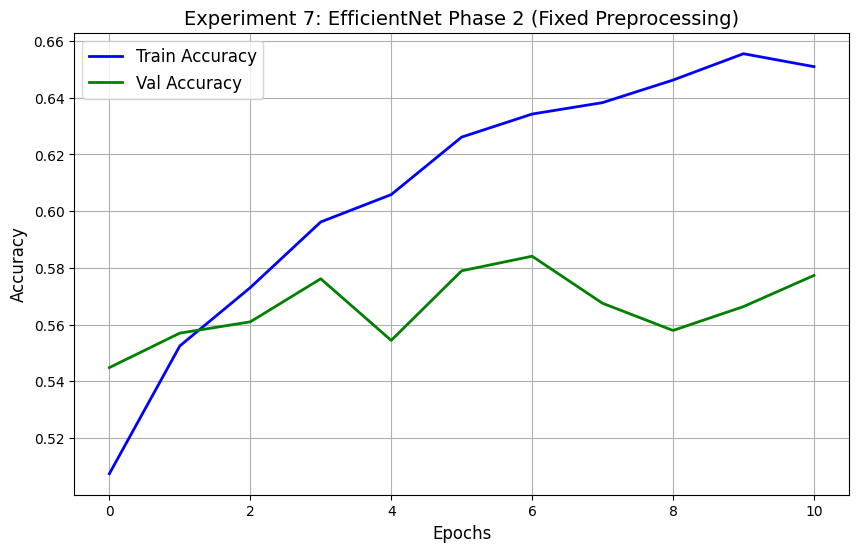

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

print("--- EXPERIMENT 7: EfficientNetB0) ---")

base_model_eff = EfficientNetB0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# PHASE 1: Freeze the base completely
base_model_eff.trainable = False

ultimate_model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,

    # THE MAGICAL FIX: Un-crush the pixels so EfficientNet can actually see them!
    layers.Rescaling(255.0),

    base_model_eff,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

# Compile for Phase 1
ultimate_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 1: Warming up the classification head (4 Epochs)...")
ultimate_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=4,
    class_weight=class_weights_dict,
    verbose=1
)

# PHASE 2: Surgical Fine-Tuning
print("\nPhase 2: Unfreezing top 30 layers for High-Accuracy Fine-Tuning...")
base_model_eff.trainable = True
for layer in base_model_eff.layers[:-30]:
    layer.trainable = False

ultimate_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

print("Training Phase 2... (Watch the accuracy climb this time!)")
history_ultimate = ultimate_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# Evaluate and Plot
final_acc = max(history_ultimate.history['val_accuracy'])
print(f"\n🎉 REAL Champion Model Highest Validation Accuracy: {final_acc:.4f} 🎉")

plt.figure(figsize=(10, 6))
plt.plot(history_ultimate.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history_ultimate.history['val_accuracy'], label='Val Accuracy', color='green', linewidth=2)
plt.title('Experiment 7: EfficientNet Phase 2 (Fixed Preprocessing)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [17]:
print("Upgrading Data Pipeline to High-Resolution (224x224)...")

# 1. The Magic Number for state-of-the-art CNNs
IMG_SIZE_CHAMP = [224, 224]

def process_path_champ(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize to 224x224 for maximum detail
    img = tf.image.resize(img, IMG_SIZE_CHAMP) / 255.0
    return img, label

# 2. Rebuild the Pipelines
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds_champ = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds_champ = train_ds_champ.map(process_path_champ, num_parallel_calls=AUTOTUNE)
train_ds_champ = train_ds_champ.shuffle(buffer_size=1000, seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds_champ = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds_champ = test_ds_champ.map(process_path_champ, num_parallel_calls=AUTOTUNE)
test_ds_champ = test_ds_champ.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("High-Resolution Pipeline Ready!")

Upgrading Data Pipeline to High-Resolution (224x224)...
High-Resolution Pipeline Ready!


EXPERIMENT 8: The Ultimate High-Accuracy Champion (Xception 224x224)
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training the Ultimate Champion... (This will take a bit longer due to high resolution!)
Epoch 1/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 208s 358ms/step - accuracy: 0.6592 - loss: 0.9448 - val_accuracy: 0.7381 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 2/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 187s 346ms/step - accuracy: 0.7615 - loss: 0.6545 - val_accuracy: 0.7603 - val_loss: 0.6771 - learning_rate: 1.0000e-04
Epoch 3/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 219s 378ms/step - accuracy: 0.7859 - loss: 0.5900 - val_accuracy: 0.7607 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Epoch 4/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 206s 377ms/step - accuracy: 0.7981 - loss: 0.5661 - val_accuracy: 0.7808 - val_loss: 0.6138 - learning_rate: 1.0000e-04
Epoch 5/12
535/535 ━━━━━━━━━━━━━━━━━━━━ 205s 378ms/step - accuracy: 0.8099 - loss: 0.5211 - val_accuracy: 0.7682 - val_loss: 0.6781 - learning_rate: 1.0

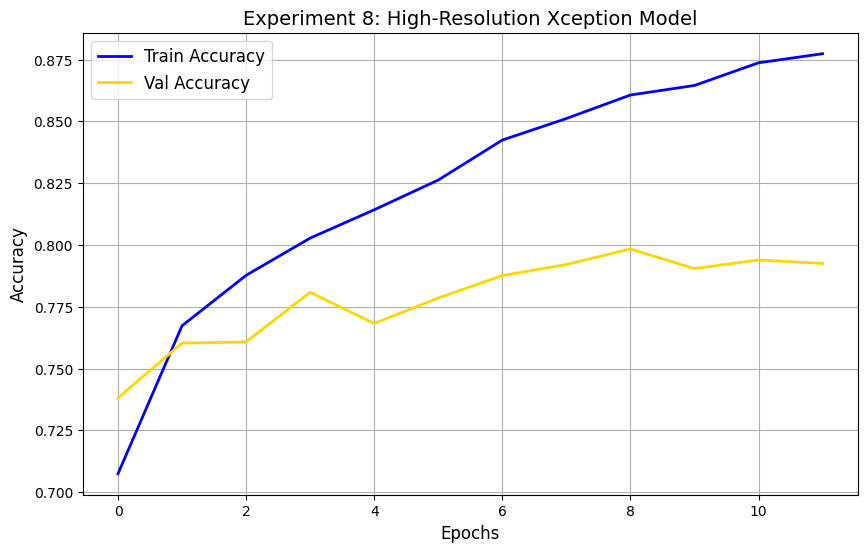

In [18]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

print("EXPERIMENT 8: The Ultimate High-Accuracy Champion (Xception 224x224)")

# 1. Create a FRESH augmentation block so it doesn't remember the old 128x128 size
champ_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# 2. Load Xception
base_model_x = Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# 3. Surgical Fine-Tuning: Freeze bottom, unfreeze the top 40 layers
base_model_x.trainable = True
for layer in base_model_x.layers[:-40]:
    layer.trainable = False

# 4. Build the Model using the NEW augmentation
ultimate_champion = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    champ_augmentation,
    base_model_x,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(5, activation='softmax')
])

# 5. Compile with a small, safe learning rate
ultimate_champion.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

print("Training the Ultimate Champion... (This will take a bit longer due to high resolution!)")
history_champ = ultimate_champion.fit(
    train_ds_champ,
    validation_data=test_ds_champ,
    epochs=12,
    callbacks=callbacks
)

# 6. Evaluate and Plot
final_acc = max(history_champ.history['val_accuracy'])
print(f"\n ULTIMATE CHAMPION VALIDATION ACCURACY: {final_acc:.4f} ")

plt.figure(figsize=(10, 6))
plt.plot(history_champ.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history_champ.history['val_accuracy'], label='Val Accuracy', color='gold', linewidth=2)
plt.title('Experiment 8: High-Resolution Xception Model', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Generating Precision-Recall Curves for the Champion Model...


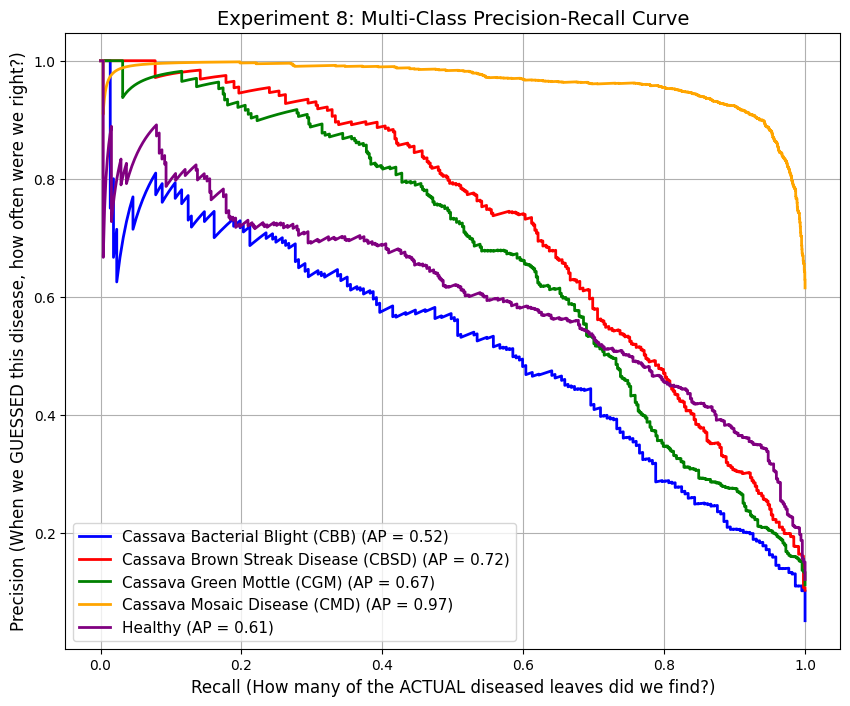

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

print("Generating Precision-Recall Curves for the Champion Model...")

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

# We use the exact same y_true_binarized and y_pred_probs_champ from your ROC cell!
for i, color in zip(range(n_classes), colors):
    # Calculate Precision and Recall
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs_champ[:, i])

    # Calculate Average Precision (AP) - similar to AUC, but for PR curves
    ap = average_precision_score(y_true_binarized[:, i], y_pred_probs_champ[:, i])

    disease_name = list(disease_map.values())[i]
    plt.plot(recall, precision, color=color, lw=2, label=f'{disease_name} (AP = {ap:.2f})')

plt.xlabel('Recall (How many of the ACTUAL diseased leaves did we find?)', fontsize=12)
plt.ylabel('Precision (When we GUESSED this disease, how often were we right?)', fontsize=12)
plt.title('Experiment 8: Multi-Class Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True)
plt.show()

Generating ROC Curves... This will take a moment.
134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step


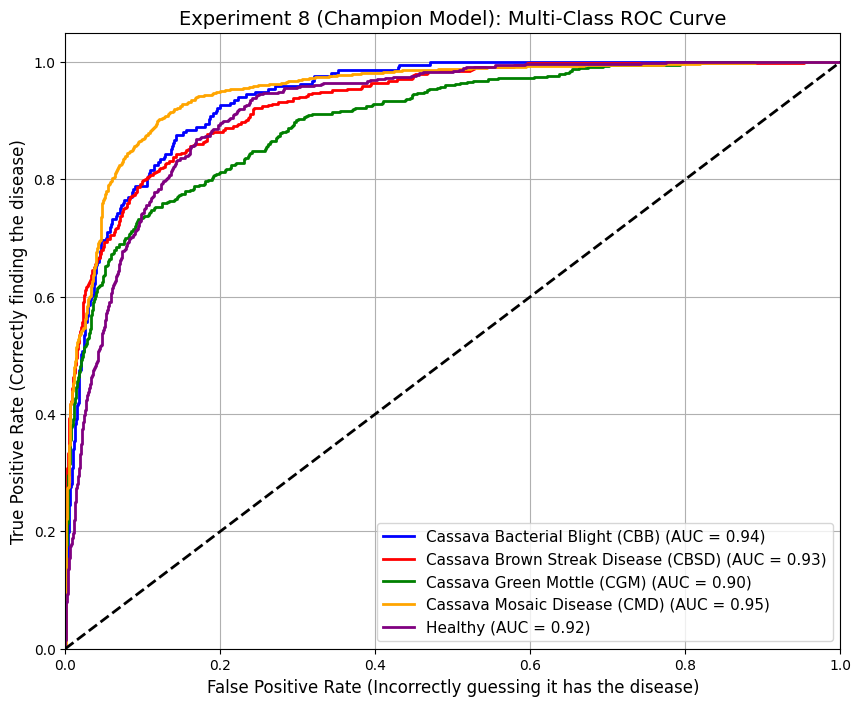

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("Generating ROC Curves... This will take a moment.")

# 1. Get true labels and predicted probabilities from our high-res test set
y_true_champ = []
for images, labels in test_ds_champ:
    y_true_champ.extend(labels.numpy())

y_true_champ = np.array(y_true_champ)
y_pred_probs_champ = ultimate_champion.predict(test_ds_champ)

# 2. Binarize the labels (We have 5 classes: 0, 1, 2, 3, 4)
n_classes = 5
y_true_binarized = label_binarize(y_true_champ, classes=[0, 1, 2, 3, 4])

# 3. Setup the plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

# 4. Calculate and plot the ROC curve for each disease
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs_champ[:, i])
    roc_auc = auc(fpr, tpr)
    disease_name = list(disease_map.values())[i] # Gets the real name
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{disease_name} (AUC = {roc_auc:.2f})')

# Plot the "random guessing" dashed line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Incorrectly guessing it has the disease)', fontsize=12)
plt.ylabel('True Positive Rate (Correctly finding the disease)', fontsize=12)
plt.title('Experiment 8 (Champion Model): Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True)
plt.show()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Define the Modular Helper Function
def plot_custom_confusion_matrix(y_true, y_pred, model_title):
    """
    Generates and formats a confusion matrix for any given model's predictions.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(disease_map.values()))

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45, colorbar=False, values_format='d')
    plt.title(f'Confusion Matrix: {model_title}', fontsize=16)
    plt.tight_layout()
    plt.show()

Helper function defined successfully!


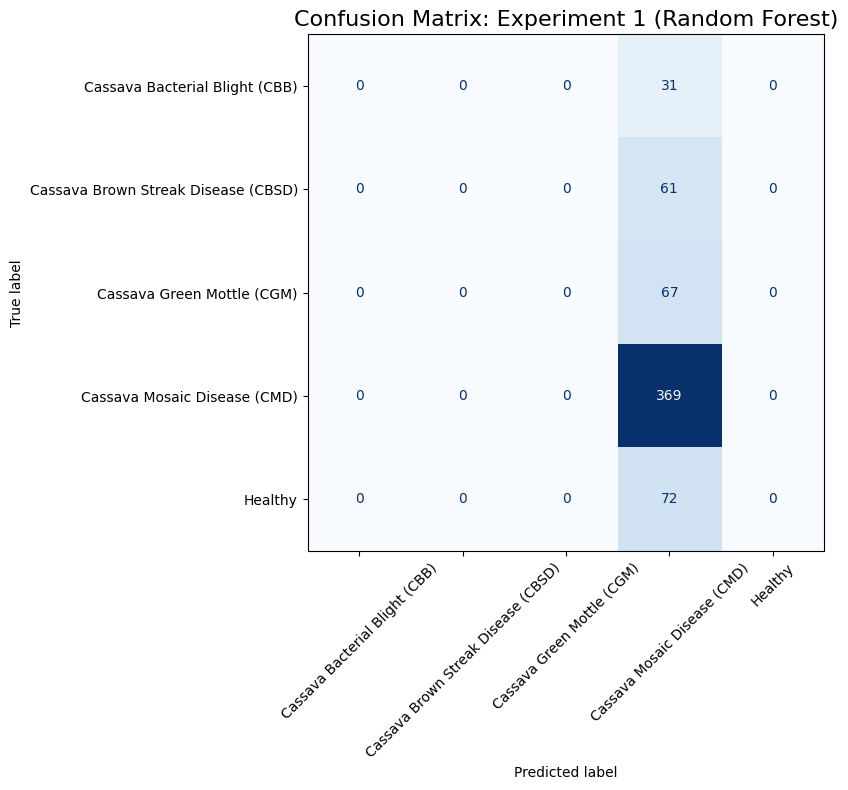

Plotting Champion Model...
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step


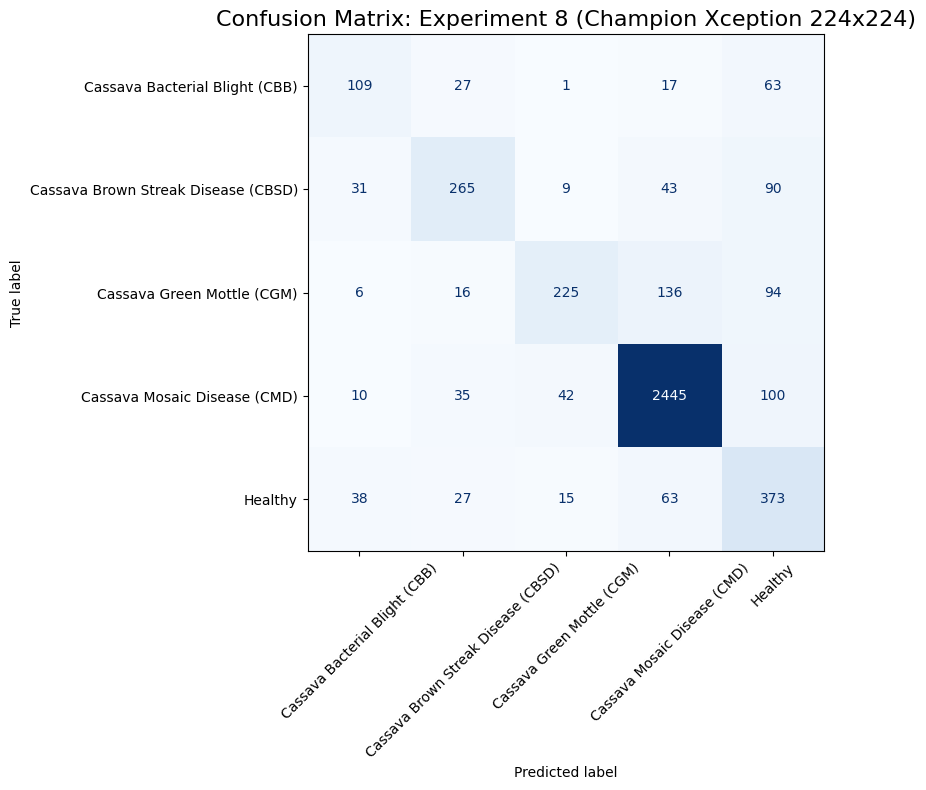

In [22]:
# 1. Traditional ML (Experiment 1: Random Forest)
plot_custom_confusion_matrix(y_test_ml, rf_preds, "Experiment 1 (Random Forest)")

# 2. The Champion Model (Experiment 8: Xception)
print("Plotting Champion Model...")
# Get the true labels from the high-res dataset
y_true_champ = []
for images, labels in test_ds_champ:
    y_true_champ.extend(labels.numpy())
y_true_champ = np.array(y_true_champ)

# Predict and convert
champ_probs = ultimate_champion.predict(test_ds_champ)
champ_preds = np.argmax(champ_probs, axis=1)

plot_custom_confusion_matrix(y_true_champ, champ_preds, "Experiment 8 (Champion Xception 224x224)")